# Stroke Prediction Analysis

>A tutorial showing how to use sklearn's logistical regression functions to predict whether a patient is prone to suffer a stroke.

- toc: false
- badges: true
- comments: true
- categories: [sklearn, logistical regression, random forests, data cleaning, python, neural network, decision trees]
- image: images/stroke.png

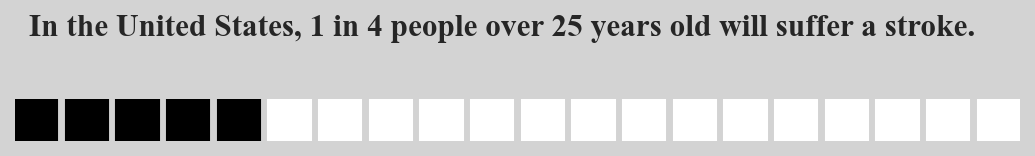

In [207]:
#hide_input
from pywaffle import Waffle
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 2),dpi=150,facecolor='lightgrey',
    FigureClass=Waffle,
    rows=1,
    values=[5, 15],
    colors=['black', "white"],
    characters ='',
    font_size=20,vertical=True,
)

fig.text(0.035,0.78,'In the United States, 1 in 4 people over 25 years old will suffer a stroke.',fontfamily='Times New Roman',fontsize=15,fontweight='bold')
plt.show()

### Overview

Welcome to my project on developing a stroke classification model. Data Science in the medical field allows for insights that can potentially save lives. The reason I choose this project is because of the high-stakes nature of the application of data science in the medical field. The dataset taken is from Kaggle, however the user did not provide a source, therefore this project's intended usage is for education purposes only. I will be utilizing random forest, decision tree, and logistical regression to acheive the highest accuracy. The glossary for the columns are listed at the end of the page.

Link to Webmd Article: https://www.webmd.com/stroke/news/20181220/1-in-4-people-over-25-will-be-hit-by-stroke#:~:text=Rates%20vary%20country%20to%20country%2C%20but%20in%20the,sciences%20at%20the%20University%20of%20Washington%2C%20in%20Seattle.

### Step 1: Importing Packages and Read Dataset

In this project, we will be using the following packages:

- Pandas: Data Manipulation and Cleaning

- Sklearn: Machine Learning Applications

- Seaborn: Data Visualization and Analysis

- NumPy: Scientific Computing

Link to Dataset: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [208]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set_style('whitegrid')

In [209]:
stroke = pd.read_csv("~/Downloads/Stroke_Data.csv")
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Step 2: Data Cleaning

The dataset contains 201 null values that are all located in the bmi column. There are two ways to handle null values, we can discard them from the dataset or insert values. In this case, I have elected to insert values because of the lack of data available in the dataset. The null values represent 3.93% of the total rows in the dataset. We could just insert the average bmi value dependent on gender and age. However, it would be a perfect time to use a decision tree to find bmi values using age and gender as my predictors. Since, I am basing my project on the webmd article indicating one in four people over 25 years old suffer a stroke, I will be filtering the data to all records above 25. After excluding people under 25 in our dataset we have a total of 3816 records. 

In [210]:
#hide_input
boolean_series = pd.isnull(stroke['bmi'])
print(f'Percentage of Null Values: {round((stroke[boolean_series].shape[0]/stroke.shape[0])*100,2)}%')

Percentage of Null Values: 3.93%


Text(0.5, 1.0, 'Heatmap of Null Values')

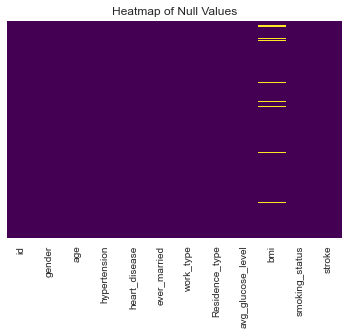

In [211]:
#hide_input
sns.heatmap(stroke.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Heatmap of Null Values')

### Step 2a: Decision Tree

Before deploying the decision tree to the dataset, the records at index 1,8,13 have null values for bmi. After executing the decision tree classification model using the predictors age and gender, we can see those same records are filled.

In [212]:
#hide_input
stroke[boolean_series].head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1


In [213]:
# Decision Tree
DT_bmi_pipe = Pipeline(steps=[('scale',StandardScaler()),('lr',DecisionTreeRegressor(random_state=101))])
X = stroke[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing_Values = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing_Values[['age','gender']]),index=Missing_Values.index)
stroke.loc[Missing_Values.index,'bmi'] = round(predicted_bmi,1)

In [214]:
#hide_input
stroke.iloc[[1,8,13],:]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.9,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,30.6,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,27.2,Unknown,1


In [215]:
stroke = stroke[(stroke['age'] > 25) & (stroke['gender'] != 'Other')]
stroke.shape

(3816, 12)

### Step 3: Exploratory Data Analysis

Exploring the data through visualizations allows us to utlize the most relevant predictors for our machine learning applications.

#### Plot 1: Pie Plot of Distribution between Genders

The first visualization presented showcases the different genders in the dataset. We have 2,296 females (60.17%), 1,520 males (39.83%).

Text(0.5, 1.0, 'Distribution of Gender')

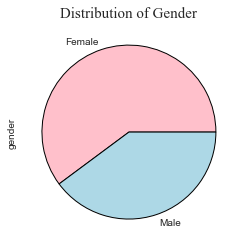

In [216]:
#collapse_hide
stroke.gender.value_counts().plot(kind = 'pie',wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'black' }, colors=['pink','lightblue'])
plt.title('Distribution of Gender',fontfamily='Times New Roman',fontsize=15)

#### Plot 2: Histogram of Age with an overlay of stroke records

Our next visualization represents the distribution of age in the dataset with an overlay of stroke patients. The shape of the distribution can be seen as multimodal with records peaking in frequency at ages 50 years old, 60 years old, and 80 years old. Where the stroke overlay shows as patients age they are likely to suffer a stroke. The shape of the stroke variable is a negative distribution, which peaks at 80 years old.

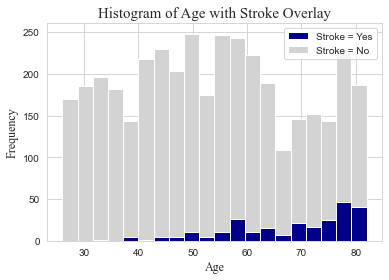

In [217]:
#collapse_hide
stroke_age_y = stroke[stroke['stroke'] == 1]['age']
stroke_age_n = stroke[stroke['stroke'] == 0]['age']

plt.hist([stroke_age_y, stroke_age_n], bins = 20, stacked = True, color = ['darkblue','lightgrey'])
plt.legend(['Stroke = Yes', 'Stroke = No'])
plt.title('Histogram of Age with Stroke Overlay',fontfamily='Times New Roman',fontsize=15)
plt.xlabel('Age',fontfamily='Times New Roman',fontsize=12)
plt.ylabel('Frequency',fontfamily='Times New Roman',fontsize=12)
plt.show()

#### Plot 3: KDE Plot of BMI with an overlay of Gender

The following visualization displays the distribution of BMI amongst genders. Both distributions are normal with a positive skew. The male distribution is steeper than female indicating the majority of values are around the mean. Where the female distribution is a flatter curve, which means the records are more spread accross the range of values.

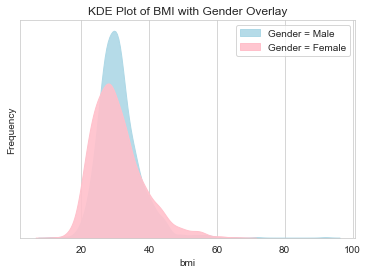

In [218]:
#collapse_hide
female_bmi = stroke[stroke['gender'] == 'Female']['bmi']
male_bmi = stroke[stroke['gender'] == 'Male']['bmi']


fig = sns.kdeplot(male_bmi, shade=True, color="lightblue", alpha = 0.9)
fig = sns.kdeplot(female_bmi, shade=True, color="pink", alpha = 0.9)
plt.legend(['Gender = Male', 'Gender = Female'])
plt.title('KDE Plot of BMI with Gender Overlay')
plt.yticks([]) 
plt.ylabel("Frequency")
plt.show()

#### Plot 4: Histogram of Age with an overlay of Hypertension

Plot four features a histogram of age with an overlay of Hypertension. The chart indicates Hypertension is applicable to all ages. However, there is a higher chance of records having Hypertension as they age.

#### Plot 5: Histogram of Age with an overlay of Heart Disease

Plot five is a histogram of age with an overlay of Heart Disease. Also, like Hypertension records are likely to have Heart Disease as they age. However, not all ages have heart disease in the dataset. 

In [219]:
#hide_input
palette = ['lightgrey','darkblue']

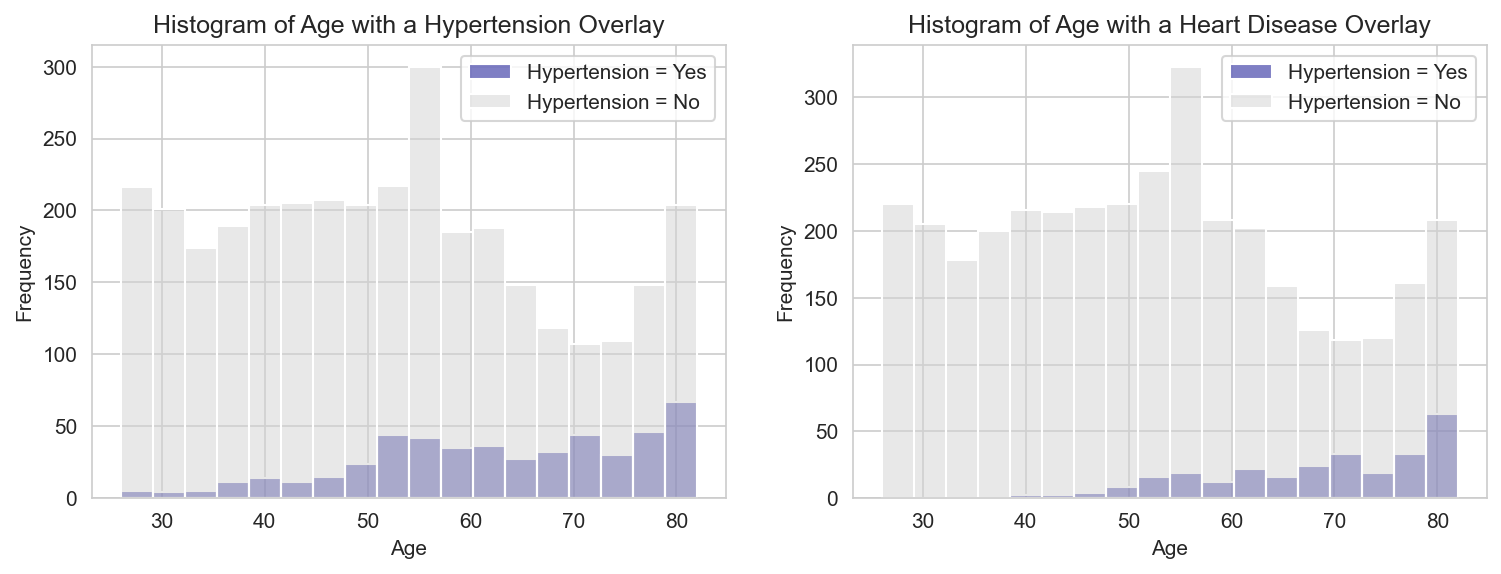

In [220]:
#collapse_hide
fig = plt.figure(figsize=(12, 4), dpi=150,facecolor='white')

plt.subplot(1,2,1)
sns.histplot(x = 'age', data = stroke, hue = 'hypertension', palette = palette)
plt.title('Histogram of Age with a Hypertension Overlay')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.legend(['Hypertension = Yes', 'Hypertension = No'])
plt.subplot(1,2,2)
sns.histplot(x = 'age', data = stroke, hue = 'heart_disease', palette = palette)
plt.title('Histogram of Age with a Heart Disease Overlay')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.legend(['Hypertension = Yes', 'Hypertension = No'])

#### Plot 6: Normalized Bar Chart of Heart Disease with a Stroke Overlay

According to the CDC the metrics below indicate whether a person is normal, prediabetes, or has diabetes.

- Normal: Under 140 mg/dL
- Prediabetes: Between 140 mg/dL and 199 mg/dL
- Diabetes: Over 200 mg/dL

Using the numerical values obtained by the CDC, we are going to bin the avg_glucose variable into categories. After producing the normalized bar chart of severity of diabetes, we can see the records that are prediabetic and have diabetes have almost double the chance of having a stroke.

In [221]:
stroke['avg_glucose_binning'] = pd.cut(x = stroke.avg_glucose_level, 
                                  bins = [0, 140, 200, 500],
                                  labels = ['Normal', 'Prediabetes', 'Diabetes'],
                                  right = False)

(array([0, 1, 2]),
 [Text(0, 0, 'Normal'), Text(1, 0, 'Prediabetes'), Text(2, 0, 'Diabetes')])

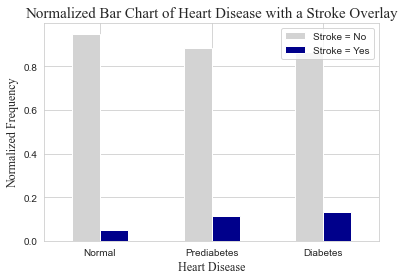

In [222]:
#collapse_hide
crosstab_09 = pd.crosstab(stroke['avg_glucose_binning'],stroke['stroke'])
crosstab_norm_09 = crosstab_09.div(crosstab_09.sum(1), axis = 0)
crosstab_norm_09.plot(kind = 'bar',color = ['lightgrey','darkblue'])
plt.title('Normalized Bar Chart of Heart Disease with a Stroke Overlay',fontfamily='Times New Roman',fontsize=15)
plt.xlabel('Heart Disease',fontfamily='Times New Roman',fontsize=12)
plt.ylabel('Normalized Frequency',fontfamily='Times New Roman',fontsize=12)
plt.legend(['Stroke = No', 'Stroke = Yes'])
plt.xticks(rotation = 360)

#### Plot 7: Regression Plot of BMI and Age with a stroke overlay

Plot seven features a scatterplot chart of age and bmi with an overlay of stroke outcome and regression line. Now we can understand that age plays one of the biggest roles in determining whether a person suffers a stroke.

Text(0.5, 6.800000000000001, 'Age')

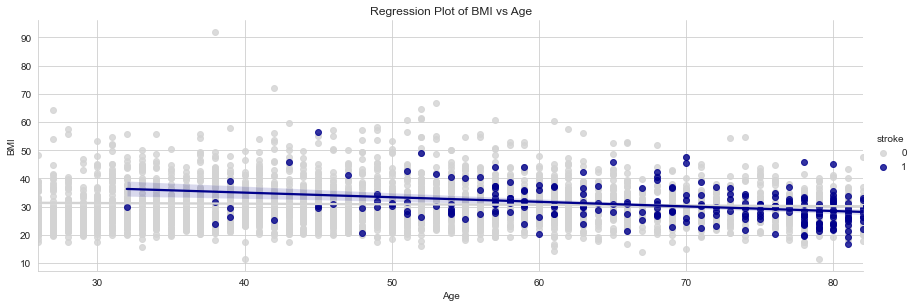

In [223]:
palette = ['lightgrey','darkblue']
sns.lmplot(x = 'age', y = 'bmi', data = stroke, hue = 'stroke', palette=palette, height = 4, aspect = 3)
plt.title('Regression Plot of BMI vs Age')
plt.ylabel('BMI')
plt.xlabel('Age')

# Machine Learning

### Spliting the Data

When spliting the data, we are able to obtain a baseline model as a benchmark for our machine learning models. Since, the data gathered features an anomaly of records without a stroke the bencmark will be remarkably high. In order to find the baseline number, we simply take the probability of all records not having a stroke. Therefore, the benchmark for our data is 93% accuracy.

In [224]:
stroke_train, stroke_test = train_test_split(stroke, 
                test_size = 0.25, random_state = 101)

In [225]:
print('Training Dataset Size:',stroke_train.shape)
print('Test Dataset Size:',stroke_test.shape)

Training Dataset Size: (2862, 13)
Test Dataset Size: (954, 13)


In [226]:
print('Baseline Test Model',round((stroke_test.stroke == 0).mean(),2))

Baseline Test Model 0.93


### Rebalance the Data

The current state of the data has an imbalance when it comes to the number of stroke outcomes amongst records. Currently 6.8% of all records in the training data had a stroke. According to the WebMD, it is the consensus that the percentage of people who obtain a stroke is around 26%. Therefore, we must rebalance the data so we have a ratio that is realistic.

In [105]:
stroke_train.stroke.value_counts()/len(stroke_train)

0    0.931866
1    0.068134
Name: stroke, dtype: float64

In [106]:
stroke_train.stroke.value_counts()

0    2667
1     195
Name: stroke, dtype: int64

In [107]:
q = 0.26
oversampling_size = (int)(((2667+195)*q - 195)/(1 - q))
print(oversampling_size)
to_resample = stroke_train[stroke_train['stroke'] == 1]
# sampling with replacement
our_resample = to_resample.sample(n = oversampling_size, 
                                 replace = True)
# to concatenate two DataFrames
stroke_train_rebal = pd.concat([stroke_train, our_resample])

742


In [108]:
stroke_train_rebal['stroke'].value_counts()

0    2667
1     937
Name: stroke, dtype: int64

In [109]:
stroke_train = stroke_train_rebal
stroke_train.shape

(3604, 13)

In [110]:
stroke_train.reset_index(inplace = True)
stroke_test.reset_index(inplace = True)

## CART Method

In [198]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(pd.DataFrame(stroke_train.smoking_status))
smoking_status_train_enc = pd.DataFrame(enc.transform(pd.DataFrame(
    stroke_train.smoking_status)).toarray(), columns = 
                                 enc.get_feature_names(['smoking_status']))
stroke_train = pd.concat([stroke_train, 
                                smoking_status_train_enc], 
                           axis = 1)

smoking_status_test_enc = pd.DataFrame(enc.transform(pd.DataFrame(
    stroke_test.smoking_status)).toarray(), columns = 
                                enc.get_feature_names(['smoking_status']))
stroke_test = pd.concat([stroke_test, smoking_status_test_enc], 
                        axis = 1)

In [199]:
y_names = ['No Stroke', 'Stroke']
predictors = ['age','hypertension','heart_disease','avg_glucose_level','bmi']
predictors.extend(smoking_status_train_enc.columns.to_list())
print(predictors, y_names)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes'] ['No Stroke', 'Stroke']


In [200]:
X_train = stroke_train[predictors]
y_train = stroke_train['stroke']

X_test = stroke_test[predictors]
y_test = stroke_test['stroke']

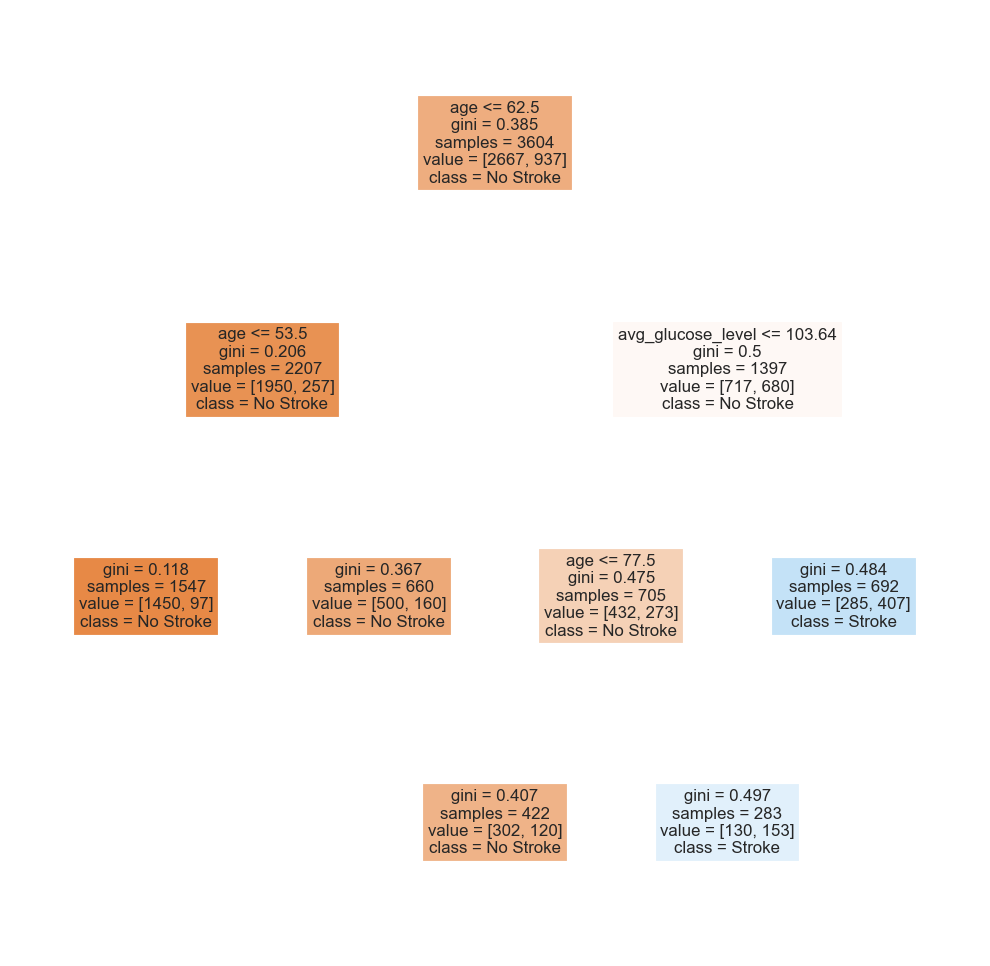

In [201]:
# train the model
cart01 = DecisionTreeClassifier(criterion = "gini", 
            max_leaf_nodes = 5).fit(
    X_train, y_train)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

tree.plot_tree(cart01,
           feature_names = predictors, 
           class_names=y_names,
           filled = True);
plt.show()

In [202]:
#test the model
pred_test = cart01.predict(X_test)

Accuracy: 0.8


In [203]:
#hide
acc_cart = round((pred_test == y_test).mean(),2)*100

### Random Forests

In [187]:
# convert a Series to a one-dimensional nd-array
rfy = np.ravel(stroke_train.stroke)
# Random Forest
rf_01 = RandomForestClassifier(n_estimators = 100, 
                    criterion = 'gini').fit(X_train, rfy)

In [188]:
# predict the outcome for the test data
pred_test = rf_01.predict(X_test)

Accuracy: 0.92


In [195]:
#hide
acc_rf = round((pred_test == y_test).mean(),2)*100

### Logistical Regression

In [190]:
# train the model
logmodel = LogisticRegression(max_iter = 500)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=500)

In [191]:
# test the model
predictions = logmodel.predict(X_test)

In [192]:
#hide
acc_log = round((predictions == y_test).mean(),2)*100

### Model Evaluation

- Precision:

- Sensitivity:

- Specificity:

- Accuracy:

In [204]:
#hide_input
models = pd.DataFrame({
    'Model': ['CART Method','Random Forests','Logistic Regression'], 
    'Precision': [1,1,2], 
    'Sensitivity' : [1,1,2], 
    'Specificity' : [1,1,2], 
    
    'Accuracy': [acc_cart,acc_rf,acc_log]})

In [205]:
#hide_input
models

,Model,Precision,Sensitivity,Specificity,Accuracy
0,CART Method,1,1,1,80.0
1,Random Forests,1,1,1,92.0
2,Logistic Regression,2,2,2,86.0


### Conclusion